In [1]:

import os
from copy import deepcopy
# import psutil
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

KeyboardInterrupt: 

In [ ]:
clean_images_dir = 'data/upscaled'
watermark_images_dir = 'data/watermark_upscaled'
segmented_watermarks_dir = 'data/segmented'


In [ ]:
# ==== Some utils

def parallelize(func, inputs, n_workers=4):
    from concurrent.futures import ThreadPoolExecutor

    with ThreadPoolExecutor(max_workers=n_workers) as executor:
        results = list(executor.map(func, inputs))
    
    return results


def sort_by_index(_strs):
    import re
    def str_index(_str):
        match = re.search(r'_(\d+)', _str)
        return int(match.group(1)) if match else float('inf')
    
    return sorted(_strs, key=str_index)


def get_image_paths(dir, n=None):
    
    n = len(os.listdir(dir)) if n is None else n
    
    valid_ext = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    paths = [os.path.join(dir, filename) for filename in sort_by_index(os.listdir(dir))[:n]
             if any(filename.lower().endswith(ext) for ext in valid_ext)]
    return paths

test_clean_images_path = get_image_paths(clean_images_dir, n=10)
test_watermark_images_path = get_image_paths(watermark_images_dir, n=10)

print(test_clean_images_path, test_watermark_images_path, sep='\n')

['data/upscaled\\image_0.jpg', 'data/upscaled\\image_1.jpg', 'data/upscaled\\image_2.jpg', 'data/upscaled\\image_3.jpg', 'data/upscaled\\image_4.jpg', 'data/upscaled\\image_5.jpg', 'data/upscaled\\image_6.jpg', 'data/upscaled\\image_7.jpg', 'data/upscaled\\image_8.jpg', 'data/upscaled\\image_9.jpg']
['data/watermark_upscaled\\image_0.png', 'data/watermark_upscaled\\image_1.png', 'data/watermark_upscaled\\image_2.png', 'data/watermark_upscaled\\image_3.png', 'data/watermark_upscaled\\image_4.png', 'data/watermark_upscaled\\image_5.png', 'data/watermark_upscaled\\image_6.png', 'data/watermark_upscaled\\image_7.png', 'data/watermark_upscaled\\image_8.png', 'data/watermark_upscaled\\image_9.jpg']


In [ ]:
def plot_images_paired_grid(images_1, images_2, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))  
    axes = axes.flatten()  

    for i, pair in enumerate(zip(images_1[:rows * cols], images_2[:rows * cols])):
        img_1, img_2 = pair
        axes[i].imshow(np.hstack((img_1, img_2)))
        axes[i].axis("off")
        
    plt.tight_layout()
    plt.show()


def plot_images_grid(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))  
    axes = axes.flatten()  

    for i, img in enumerate(images[:rows * cols]):
        axes[i].imshow(img, cmap='gray')
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()



10


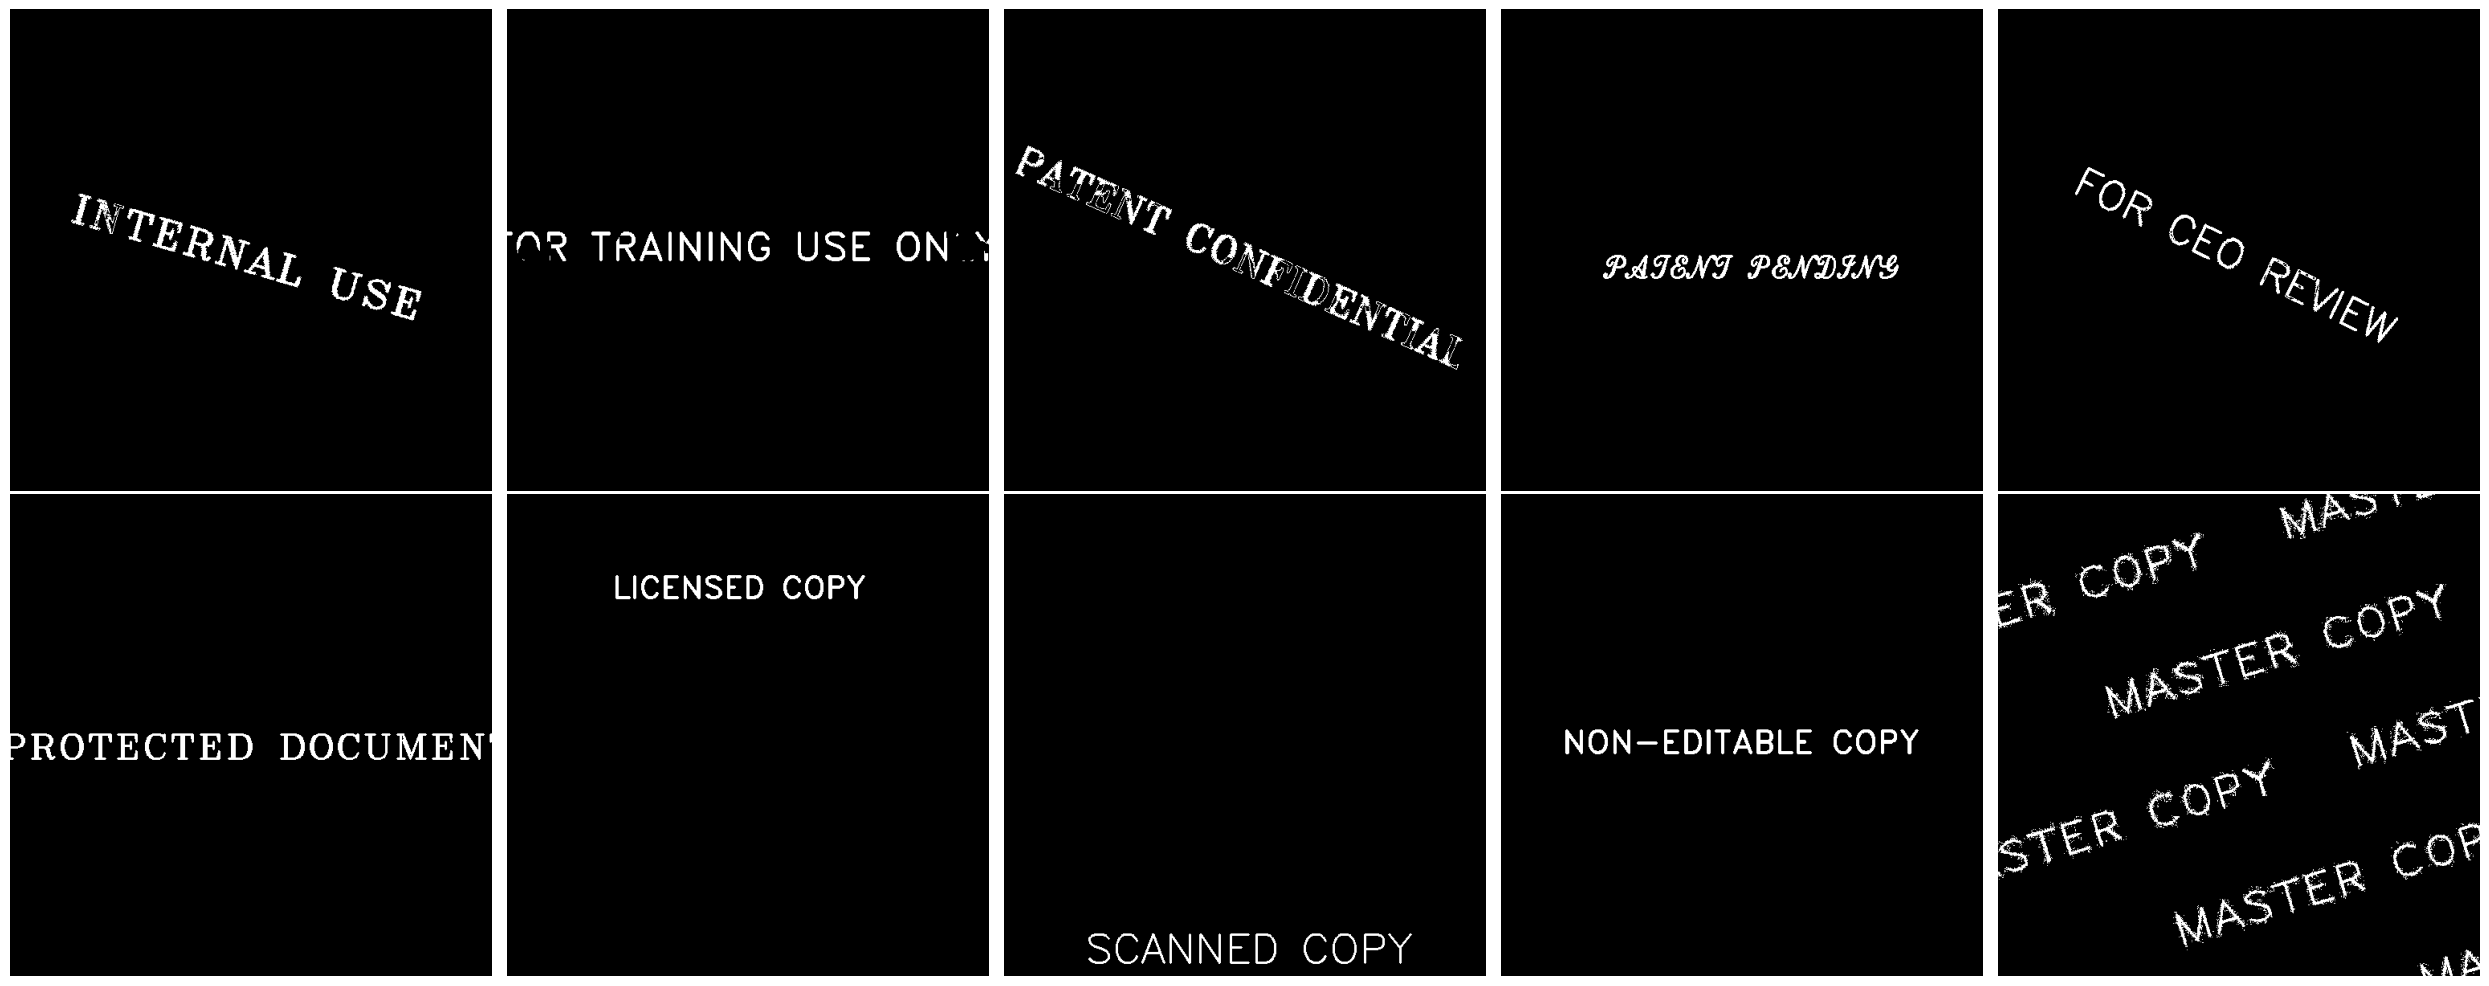

In [ ]:
def segment_watermark(clean_path, watermark_path):
    clean_gray = cv2.imread(clean_path, cv2.IMREAD_GRAYSCALE)
    watermark_gray = cv2.imread(watermark_path, cv2.IMREAD_GRAYSCALE)
    
    if clean_gray is None or watermark_gray is None:
        raise ValueError("One or both of the images could not be loaded.")

    diff = cv2.absdiff(clean_gray, watermark_gray)
    _, thresh_segmented = cv2.threshold(diff, 10, 255, cv2.THRESH_BINARY)
    return thresh_segmented


test_segmented = [segment_watermark(clean_path, wm_path)  
                  for clean_path, wm_path in zip(test_clean_images_path , test_watermark_images_path)]


print(len(test_segmented))
plot_images_grid(test_segmented, rows=2, cols=5)





In [ ]:
def save_segmented_wms(clean_dir, watermark_dir, out_dir, n_workers=4):
    os.makedirs(out_dir, exist_ok=True)
    clean_images_path = get_image_paths(clean_dir)
    watermark_images_path = get_image_paths(watermark_dir)
    
    def save_f(args, out_dir=out_dir):
        try:
            clean_path, watermark_path = args
            segmented = segment_watermark(clean_path, watermark_path)
            out_path = os.path.join(out_dir, os.path.basename(clean_path))
            cv2.imwrite(out_path, segmented)
        except Exception as e:
            print(f'{e}')
    
    inputs = zip(clean_images_path, watermark_images_path)
    parallelize(save_f, inputs, n_workers=n_workers)

In [ ]:
# save_segmented_wms(
#     clean_images_dir, watermark_images_dir, 
#     segmented_watermarks_dir, n_workers=6)

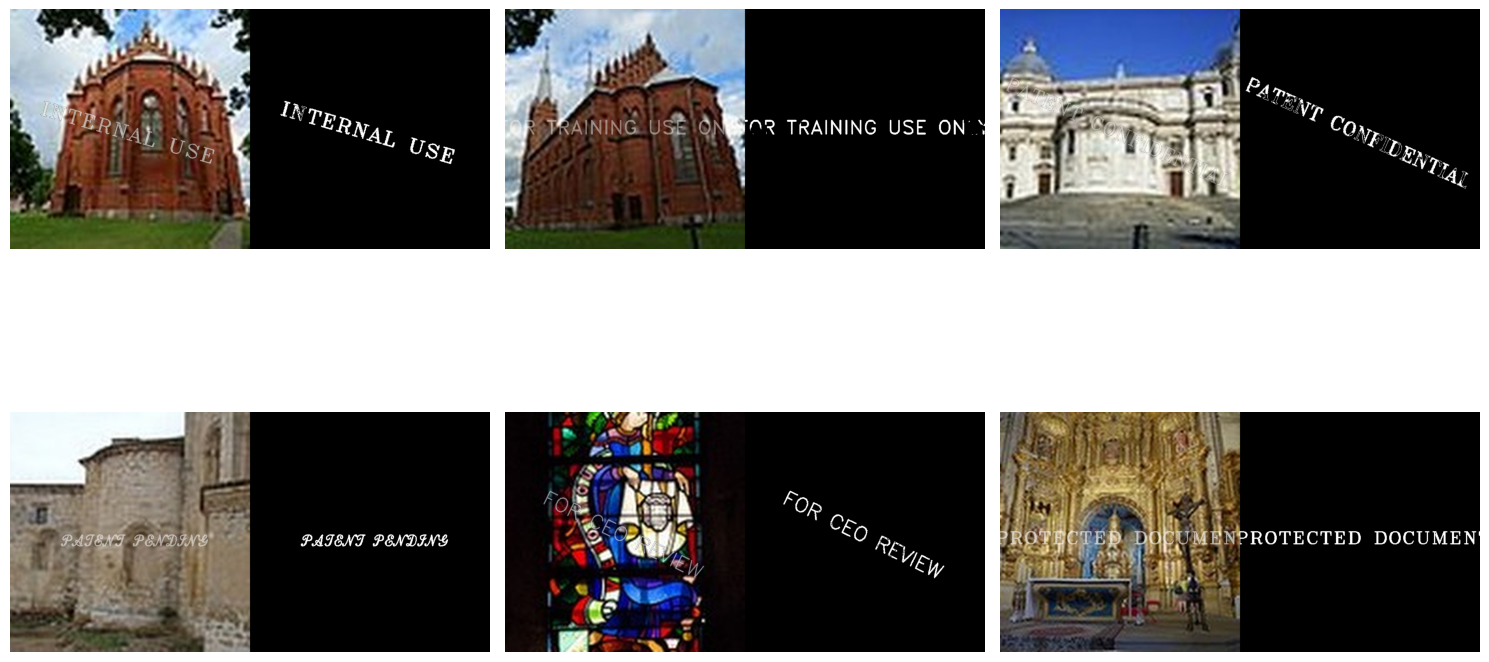

In [ ]:
test_wm_images = [cv2.imread(path, cv2.IMREAD_COLOR_RGB) for path in get_image_paths(watermark_images_dir, n=6)]
test_segment_images = [cv2.imread(path, cv2.IMREAD_COLOR_RGB) for path in get_image_paths(segmented_watermarks_dir, n=6)]
wm_segment_pairs = [np.hstack((wm, seg)) for wm, seg in zip(test_wm_images, test_segment_images)]

plot_images_grid(wm_segment_pairs, rows=2, cols=3)

In [ ]:


class WatermarkDataset(Dataset):
    """Some Information about WatermarkDataset"""
    def __init__(self, clean_dir, wm_dir, segment_dir, n=None, transform=None):
        super(WatermarkDataset, self).__init__()
        self.clean_dir = clean_dir
        self.wm_dir = wm_dir
        self.segment_dir = segment_dir
        self.clean_images_path = get_image_paths(self.clean_dir, n=n)
        self.wm_images_path = get_image_paths(self.wm_dir, n=n)
        self.segment_images_path = get_image_paths(self.segment_dir, n=n)
        self.transform = transform

    def __getitem__(self, index):
        clean_img = cv2.imread(self.clean_images_path[index], cv2.IMREAD_COLOR)
        wm_img = cv2.imread(self.wm_images_path[index], cv2.IMREAD_COLOR)
        segment_img = cv2.imread(self.segment_images_path[index], cv2.IMREAD_GRAYSCALE)

        if clean_img is None or wm_img is None or segment_img is None:
            raise RuntimeError(f"Error loading image at index {index}")

        clean_img = cv2.cvtColor(clean_img, cv2.COLOR_BGR2RGB)
        wm_img = cv2.cvtColor(wm_img, cv2.COLOR_BGR2RGB)

        if self.transform:
            clean_img = self.transform(clean_img)
            wm_img = self.transform(wm_img)
            segment_img = transforms.ToTensor()(segment_img)

        return clean_img, wm_img, segment_img

    def __len__(self):
        return min(len(self.clean_images_path), len(self.segment_images_path), len(self.wm_images_path))



In [ ]:
transforms_ = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((256, 256)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = WatermarkDataset(
    clean_images_dir, 
    watermark_images_dir, 
    segmented_watermarks_dir, 
    n=1000, 
    transform=transforms_
)

train_loader = DataLoader(dataset, batch_size=16, shuffle=False)

for clean, wm, segment in train_loader:
    print(clean.shape, wm.shape, segment.shape)  
    break

torch.Size([16, 3, 600, 600]) torch.Size([16, 3, 600, 600]) torch.Size([16, 1, 600, 600])
